In [ ]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

<ipython-input-2-f939ec2835ff>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [ ]:
def parser(x):
	return datetime.strptime(x, '%Y-%m')

def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

def scale(train, test):
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)

	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

In [ ]:
series = read_csv('monthly-sunspot-number-zurich-17.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)


<ipython-input-4-42a4c8e121a4>:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = read_csv('monthly-sunspot-number-zurich-17.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)


In [ ]:
series.head()


Month
1749-01-01    58.0
1749-02-01    62.6
1749-03-01    70.0
1749-04-01    55.7
1749-05-01    85.0
Name: Monthly sunspot number, dtype: float64

In [ ]:
raw_values = series.values
diff_values = difference(raw_values, 1)

In [ ]:
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [ ]:
print(supervised_values)


[[  0.    4.6]
 [  4.6   7.4]
 [  7.4 -14.3]
 ...
 [-21.5   5.5]
 [  5.5 -22.5]
 [-22.5   0.1]]


In [ ]:
supervised_values.shape


(2819, 2)

In [ ]:
train, test = supervised_values[0:-2184], supervised_values[-2184:]

scaler, train_scaled, test_scaled = scale(train, test)

In [ ]:
lstm_model = fit_lstm(train_scaled, 1, 50, 1)
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

predictions = list()

635/635 [==============================] - 1s 2ms/step


In [ ]:
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

1/1 [==============================] - 0s 19ms/step
Month=1, Predicted=44.509912, Expected=47.800000
1/1 [==============================] - 0s 20ms/step
Month=2, Predicted=47.540079, Expected=47.000000
1/1 [==============================] - 0s 19ms/step
Month=3, Predicted=48.241118, Expected=40.800000
1/1 [==============================] - 0s 20ms/step
Month=4, Predicted=44.781513, Expected=42.000000
1/1 [==============================] - 0s 19ms/step
Month=5, Predicted=43.740703, Expected=44.000000
1/1 [==============================] - 0s 21ms/step
Month=6, Predicted=44.527684, Expected=46.000000
1/1 [==============================] - 0s 19ms/step
Month=7, Predicted=46.167635, Expected=48.000000
1/1 [==============================] - 0s 22ms/step
Month=8, Predicted=48.066077, Expected=50.000000
1/1 [==============================] - 0s 20ms/step
Month=9, Predicted=50.037193, Expected=51.800000
1/1 [==============================] - 0s 19ms/step
Month=10, Predicted=51.920818, Expected

In [ ]:
rmse = sqrt(mean_squared_error(raw_values[-2184:], predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 15.938


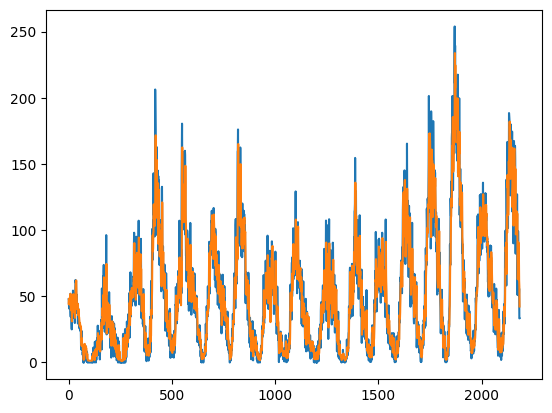

In [ ]:
pyplot.plot(raw_values[-2184:])
pyplot.plot(predictions)
pyplot.show()

In [ ]:
raw_values.shape


(2820,)

In [ ]:
print(len(predictions))


2184
